# RNN Framework for Graph Node Degree Prediction

This notebook implements a Recurrent Neural Network (RNN) framework that predicts node degrees based on node types in a graph. The input consists of pathways generated by a random walker traversing the graph.

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
from typing import List, Dict, Tuple
import os
from hetmatpy.hetmat import hetmat_from_graph
from hetmatpy.hetmat import HetMat
import hetnetpy
import networkx as nx

from sklearn.model_selection import train_test_split

## 1. Load Hetionet


In [2]:
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetnetpy.readwrite.read_graph(url)




In [3]:
nodes = graph.get_nodes()
# Get total number of nodes
num_nodes = len(list(nodes))
print(f"Total number of nodes: {num_nodes}")

# Get total number of edges
edges = graph.get_edges()
num_edges = len(list(edges))
print(f"Total number of edges: {num_edges}")

Total number of nodes: 47031
Total number of edges: 2250197
Total number of edges: 2250197


In [4]:
# Convert hetionet graph to networkx graph
G_nx = nx.MultiGraph()

# Add nodes with attributes from hetionet graph
for node in graph.get_nodes():
    G_nx.add_node(node.identifier, 
                  node_type=node.metanode.identifier,
                  name=node.name,
                  data=node.data)

# Add edges from hetionet graph
for edge in graph.get_edges():
    source = edge.source.identifier
    target = edge.target.identifier
    G_nx.add_edge(source, target, 
                  edge_type=edge.metaedge.kind,
                  data=edge.data)

print(f"Created NetworkX graph with {G_nx.number_of_nodes()} nodes and {G_nx.number_of_edges()} edges")

Created NetworkX graph with 47031 nodes and 2250197 edges


In [5]:
# Check for disease nodes in G_nx
disease_nodes = [n for n, d in G_nx.nodes(data=True) if d.get('node_type') == 'Disease']
print(f"Number of disease nodes: {len(disease_nodes)}")
print("Sample disease nodes:")
for n in disease_nodes[:5]:
    print(n)

Number of disease nodes: 137
Sample disease nodes:
DOID:14227
DOID:9352
DOID:8778
DOID:5612
DOID:363


In [13]:
# Get unique node types from G_nx
node_types = set(data['node_type'] for _, data in G_nx.nodes(data=True))


# Print count of nodes for each type
print("\nNode count by type:")
for node_type in sorted(node_types):
    count = sum(1 for _, data in G_nx.nodes(data=True) if data['node_type'] == node_type)
    print(f"- {node_type}: {count} nodes")


Node count by type:
- Anatomy: 402 nodes
- Biological Process: 11381 nodes
- Cellular Component: 1391 nodes
- Compound: 1552 nodes
- Disease: 137 nodes
- Gene: 20945 nodes
- Molecular Function: 2884 nodes
- Pathway: 1822 nodes
- Pharmacologic Class: 345 nodes
- Side Effect: 5734 nodes
- Symptom: 438 nodes


In [6]:
# Get unique edge types from G_nx
edge_types = set(data['edge_type'] for u, v, data in G_nx.edges(data=True))

# Print the unique edge types
print("Unique edge types in the graph:")
for edge_type in sorted(edge_types):
    print(f"- {edge_type}")

Unique edge types in the graph:
- associates
- binds
- causes
- covaries
- downregulates
- expresses
- includes
- interacts
- localizes
- palliates
- participates
- presents
- regulates
- resembles
- treats
- upregulates


## 2. Predict Pathway Degree Products for GeAlD Metapath Using RNN

We will sample random walks along the Gene expresses Anatomy localizes Disease (GeAlD) metapath, compute degree-weighted pathway counts (DWPCs), and use a recurrent neural network to predict the distribution of DWPCs.

In [70]:
# 1. Generate Gene-Anatomy walks
def generate_gene_anatomy_walks(G_nx, num_walks=10000):
    walks = []
    # Get nodes by type
    gene_nodes = [n for n, d in G_nx.nodes(data=True) if d.get('node_type') == 'Gene']
    
    for _ in range(num_walks):
        # Start with a random gene
        gene = random.choice(gene_nodes)
        # Find connected anatomy nodes
        anatomy_neighbors = [n for n in G_nx.neighbors(gene) 
                           if G_nx.nodes[n].get('node_type') == 'Anatomy']        
        if anatomy_neighbors:
            # Select random anatomy neighbor
            anatomy = random.choice(anatomy_neighbors)
            walks.append((gene, anatomy))
                # Find connected disease nodes from anatomy
        disease_neighbors = [n for n in G_nx.neighbors(anatomy) 
                            if G_nx.nodes[n].get('node_type') == 'Disease']
        if disease_neighbors:
                # Select random disease neighbor
            disease = random.choice(disease_neighbors)
            walks[-1] = (gene, anatomy, disease)
    return walks

# Generate walks
gene_anatomy_walks = generate_gene_anatomy_walks(G_nx)
print(f"Generated {len(gene_anatomy_walks)} Gene-Anatomy walks")

# Print some sample walks
print("\nSample Gene-Anatomy-Disease walks:")
for walk in gene_anatomy_walks[:5]:
    gene, anatomy, disease = walk
    print(f"Gene {gene} -> Anatomy {anatomy} -> Disease {disease}")

# Store walks for later use
geald_walks = gene_anatomy_walks


Generated 8693 Gene-Anatomy walks

Sample Gene-Anatomy-Disease walks:
Gene 3485 -> Anatomy UBERON:0001305 -> Disease DOID:2394
Gene 101930049 -> Anatomy UBERON:0002368 -> Disease DOID:2355
Gene 2706 -> Anatomy UBERON:0002046 -> Disease DOID:12361
Gene 7316 -> Anatomy UBERON:0002240 -> Disease DOID:0050425
Gene 644844 -> Anatomy UBERON:0002046 -> Disease DOID:12306


In [71]:
# Check if all walks have length 3
all_length_3 = all(len(walk) == 3 for walk in geald_walks)
print(f"All walks are length 3: {all_length_3}")

# Get unique walk lengths
unique_lengths = set(len(walk) for walk in geald_walks)
print(f"\nUnique walk lengths: {unique_lengths}")

# Count walks by length
length_counts = {}
for walk in geald_walks:
    length = len(walk)
    length_counts[length] = length_counts.get(length, 0) + 1

print("\nWalk counts by length:")
for length, count in sorted(length_counts.items()):
    print(f"Length {length}: {count} walks")

All walks are length 3: False

Unique walk lengths: {2, 3}

Walk counts by length:
Length 2: 80 walks
Length 3: 8613 walks


In [72]:
# Filter out incomplete walks (length 2)
geald_walks = [walk for walk in geald_walks if len(walk) == 3]

print(f"Number of complete walks (length 3): {len(geald_walks)}")
print("\nSample complete walks:")
for walk in geald_walks[:5]:
    gene, anatomy, disease = walk
    print(f"Gene {gene} -> Anatomy {anatomy} -> Disease {disease}")

Number of complete walks (length 3): 8613

Sample complete walks:
Gene 3485 -> Anatomy UBERON:0001305 -> Disease DOID:2394
Gene 101930049 -> Anatomy UBERON:0002368 -> Disease DOID:2355
Gene 2706 -> Anatomy UBERON:0002046 -> Disease DOID:12361
Gene 7316 -> Anatomy UBERON:0002240 -> Disease DOID:0050425
Gene 644844 -> Anatomy UBERON:0002046 -> Disease DOID:12306


In [73]:
# Get all nodes that appear in geald_walks
walk_nodes = set()
for walk in geald_walks:
    walk_nodes.update(walk)

# Check degrees of nodes in walks
zero_degree_nodes = [n for n in walk_nodes if G_nx.degree(n) == 0]

print(f"Number of nodes in walks with degree 0: {len(zero_degree_nodes)}")
if zero_degree_nodes:
    print("\nNodes with degree 0:")
    for node in zero_degree_nodes:
        print(f"Node: {node}, Type: {G_nx.nodes[node]['node_type']}")

Number of nodes in walks with degree 0: 607

Nodes with degree 0:
Node: 100532727, Type: Gene
Node: 197350, Type: Gene
Node: 100534012, Type: Gene
Node: 2574, Type: Gene
Node: 2763, Type: Gene
Node: 2860, Type: Gene
Node: 199800, Type: Gene
Node: 101059906, Type: Gene
Node: 101059918, Type: Gene
Node: 101060026, Type: Gene
Node: 101060160, Type: Gene
Node: 101060171, Type: Gene
Node: 101060200, Type: Gene
Node: 101060226, Type: Gene
Node: 101060341, Type: Gene
Node: 101060386, Type: Gene
Node: 101060399, Type: Gene
Node: 101060405, Type: Gene
Node: 101060458, Type: Gene
Node: 200609, Type: Gene
Node: 101060580, Type: Gene
Node: 101060588, Type: Gene
Node: 101060825, Type: Gene
Node: 4431, Type: Gene
Node: 4447, Type: Gene
Node: 4473, Type: Gene
Node: 266667, Type: Gene
Node: 790969, Type: Gene
Node: 4612, Type: Gene
Node: 5084, Type: Gene
Node: 100996401, Type: Gene
Node: 100996414, Type: Gene
Node: 100996556, Type: Gene
Node: 100996571, Type: Gene
Node: 100996573, Type: Gene
Node: 100

In [75]:
# Remove walks that contain nodes with zero degrees
geald_walks_filtered = [walk for walk in geald_walks if all(G_nx.degree(node) > 0 for node in walk)]

print(f"Original number of walks: {len(geald_walks)}")
print(f"Number of walks after filtering zero-degree nodes: {len(geald_walks_filtered)}")



# Verify no zero degree nodes remain
walk_nodes_filtered = set()
for walk in geald_walks:
    walk_nodes_filtered.update(walk)
    
zero_degree_nodes_filtered = [n for n in walk_nodes_filtered if G_nx.degree(n) == 0]
print(f"\nNumber of zero-degree nodes in filtered walks: {len(zero_degree_nodes_filtered)}")

# Update geald_walks for use in subsequent cells
geald_walks = geald_walks_filtered

Original number of walks: 7868
Number of walks after filtering zero-degree nodes: 7868

Number of zero-degree nodes in filtered walks: 0


In [76]:
# 2. Calculate pathway degree products
def calculate_pdp(walks, G_nx):
    pdps = []
    for walk in walks:
        # Get degrees for each node in the walk
        degrees = [G_nx.degree(node) for node in walk]
        # Calculate degree product (multiply all degrees)
        degree_product = np.prod(degrees)
        pdps.append(degree_product)
    
    # Convert to numpy array and normalize by mean
    pdps = np.array(pdps)
    pdps = pdps ** (-0.5)
    return pdps

# Calculate DWPCs for GeAlD walks
geald_dwpcs = calculate_pdp(geald_walks, G_nx)

print(f"Calculated {len(geald_dwpcs)} DWPCs")
print(f"DWPC statistics:")
print(f"Mean: {np.mean(geald_dwpcs):.5f}")
print(f"Std: {np.std(geald_dwpcs):.5f}")
print(f"Min: {np.min(geald_dwpcs):.5f}")
print(f"Max: {np.max(geald_dwpcs):.5f}")

Calculated 7868 DWPCs
DWPC statistics:
Mean: 0.00011
Std: 0.00028
Min: 0.00001
Max: 0.01188


In [77]:
# 3. Prepare data for RNN (sequence features and targets)
import torch
from torch.utils.data import Dataset, DataLoader

class GeAlDDataset(Dataset):
    def __init__(self, walks, dwpcs, G_nx):
        self.walks = walks
        self.dwpcs = dwpcs
        self.G_nx = G_nx
    def __len__(self):
        return len(self.walks)
    def __getitem__(self, idx):
        walk = self.walks[idx]
        # Feature: node degrees for each step
        features = [self.G_nx.degree(n) for n in walk]
        target = self.dwpcs[idx]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

dataset = GeAlDDataset(geald_walks, geald_dwpcs, G_nx)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(f"Prepared dataset with {len(dataset)} samples.")

Prepared dataset with 7868 samples.


In [82]:
# 4. Define and train RNN model for DWPC prediction (updated for more complexity and epochs)
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=3):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # last hidden state
        out = self.fc(out)
        return out.squeeze(-1)

model = SimpleRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop (increased epochs)
for epoch in range(50):
    total_loss = 0
    for features, target in dataloader:
        optimizer.zero_grad()
        output = model(features)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 5, Loss: 0.0000
Epoch 10, Loss: 0.0001
Epoch 10, Loss: 0.0001
Epoch 15, Loss: 0.0001
Epoch 15, Loss: 0.0001
Epoch 20, Loss: 0.0001
Epoch 20, Loss: 0.0001
Epoch 25, Loss: 0.0000
Epoch 25, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 35, Loss: 0.0000
Epoch 35, Loss: 0.0000
Epoch 40, Loss: 0.0004
Epoch 40, Loss: 0.0004
Epoch 45, Loss: 0.0002
Epoch 45, Loss: 0.0002
Epoch 50, Loss: 0.0003
Epoch 50, Loss: 0.0003


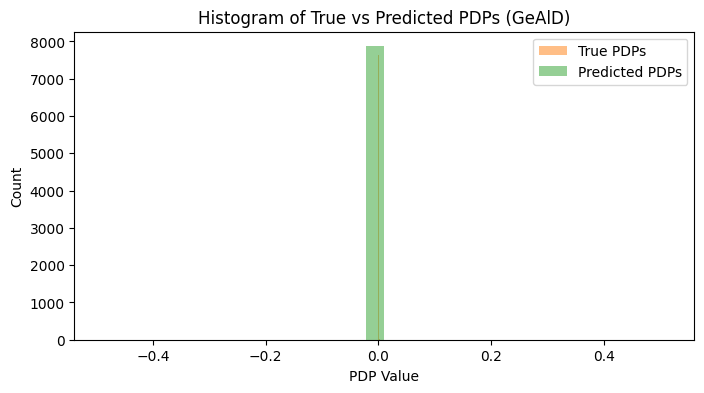

In [86]:
# 5. Predict and visualize PDP histograms (normal scale, limited x-axis)
import matplotlib.pyplot as plt

model.eval()
pred_pdps = []
true_pdps = []
with torch.no_grad():
    for features, target in dataloader:
        output = model(features)
        pred_pdps.extend(output.numpy())
        true_pdps.extend(target.numpy())

plt.figure(figsize=(8,4))
bins = 30
plt.hist(true_pdps, bins=bins, alpha=0.5, label='True PDPs', color='tab:orange')
plt.hist(pred_pdps, bins=bins, alpha=0.5, label='Predicted PDPs', color='tab:green')
plt.xlabel('PDP Value')
plt.ylabel('Count')
plt.title('Histogram of True vs Predicted PDPs (GeAlD)')
plt.legend()
plt.show()

In [87]:
# Check for negative predictions
neg_preds = [p for p in pred_pdps if p < 0]
print(f"Number of negative predictions: {len(neg_preds)}")

if len(neg_preds) > 0:
    print("\nStatistics of negative predictions:")
    print(f"Mean: {np.mean(neg_preds):.5f}")
    print(f"Min: {np.min(neg_preds):.5f}")
    print(f"Max: {np.max(neg_preds):.5f}")
    
    # Replace negative predictions with 0
    pred_pdps = [max(0, p) for p in pred_pdps]
    
    print("\nAfter replacing negatives with 0:")
    print(f"Min prediction: {min(pred_pdps):.5f}")
    print(f"Max prediction: {max(pred_pdps):.5f}")

Number of negative predictions: 0


In [84]:
# 5b. Evaluate RNN model using train/test split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Subset
import numpy as np

# Split indices for train/test
indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

def get_predictions(model, dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for features, target in loader:
            output = model(features)
            preds.extend(output.numpy())
            trues.extend(target.numpy())
    return np.array(preds), np.array(trues)

train_preds, train_trues = get_predictions(model, train_dataset)
test_preds, test_trues = get_predictions(model, test_dataset)

train_mse = mean_squared_error(train_trues, train_preds)
test_mse = mean_squared_error(test_trues, test_preds)
train_r2 = r2_score(train_trues, train_preds)
test_r2 = r2_score(test_trues, test_preds)

print(f"Train MSE: {train_mse:.6f}, R2: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.6f}, R2: {test_r2:.4f}")

Train MSE: 0.000114, R2: -1264.5188
Test MSE: 0.000114, R2: -3403.7991


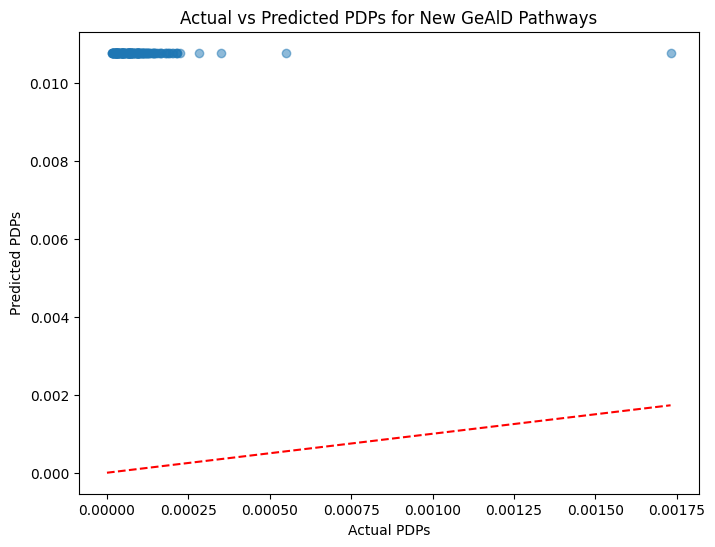

In [85]:
# Generate new sample of GeAlD walks and calculate their PDPs
test_walks = generate_gene_anatomy_walks(G_nx, num_walks=200)
test_walks = [walk for walk in test_walks if len(walk) == 3]  # Filter for complete walks
# Filter test walks to remove any containing zero degree nodes
test_walks = [walk for walk in test_walks if all(G_nx.degree(node) > 0 for node in walk)]

# Calculate actual PDPs for test walks
test_pdps = calculate_pdp(test_walks, G_nx)

# Create dataset and dataloader for test walks
test_dataset = GeAlDDataset(test_walks, test_pdps, G_nx)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get model predictions
model.eval()
pred_pdps_test = []
true_pdps_test = []
with torch.no_grad():
    for features, target in test_loader:
        output = model(features)
        pred_pdps_test.extend(output.numpy())
        true_pdps_test.extend(target.numpy())

# Create scatter plot of actual vs predicted PDPs
plt.figure(figsize=(8, 6))
plt.scatter(true_pdps_test, pred_pdps_test, alpha=0.5)
plt.plot([0, max(true_pdps_test)], [0, max(true_pdps_test)], 'r--')  # Perfect prediction line
plt.xlabel('Actual PDPs')
plt.ylabel('Predicted PDPs')
plt.title('Actual vs Predicted PDPs for New GeAlD Pathways')


plt.show()

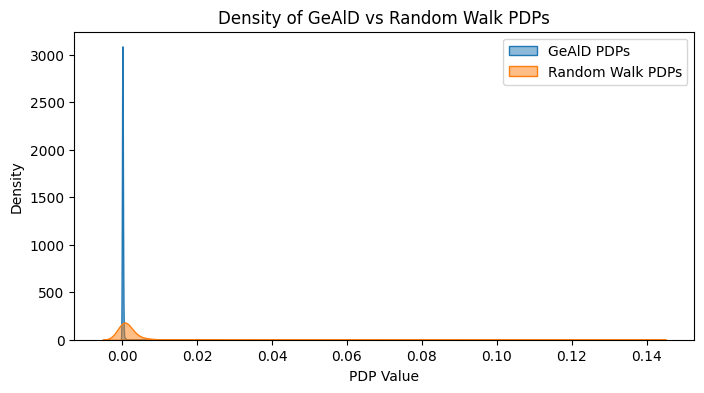

In [55]:
# 8. Compare GeAlD PDPs to random metapath walks
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample random walks of any metapath type (length 3)
def sample_random_walks(G_nx, num_walks=1000):
    walks = []
    nodes = list(G_nx.nodes())
    for _ in range(num_walks):
        walk = [random.choice(nodes)]
        for _ in range(2):
            neighbors = list(G_nx.neighbors(walk[-1]))
            if neighbors:
                walk.append(random.choice(neighbors))
            else:
                break
        if len(walk) == 3:
            walks.append(tuple(walk))
    return walks

random_walks = sample_random_walks(G_nx, num_walks=1000)
random_pdps = [np.prod([G_nx.degree(n) for n in walk]) for walk in random_walks]
random_pdps = np.array(random_pdps)
random_pdps = random_pdps ** (-0.5)


plt.figure(figsize=(8,4))
sns.kdeplot(true_pdps, label='GeAlD PDPs', fill=True, alpha=0.5)
sns.kdeplot(random_pdps, label='Random Walk PDPs', fill=True, alpha=0.5)
plt.xlabel('PDP Value')
plt.ylabel('Density')
plt.title('Density of GeAlD vs Random Walk PDPs')
plt.legend()
plt.show()

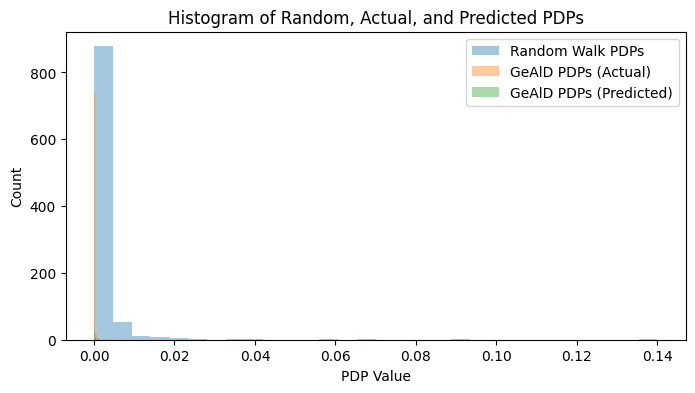

In [59]:
# 9. Histogram of random, actual (GeAlD), and predicted PDPs
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
bins = 30
plt.hist(random_pdps, bins=bins, alpha=0.4, label='Random Walk PDPs', color='tab:blue')
plt.hist(true_pdps, bins=bins, alpha=0.4, label='GeAlD PDPs (Actual)', color='tab:orange')
plt.hist(pred_pdps, bins=bins, alpha=0.4, label='GeAlD PDPs (Predicted)', color='tab:green')
plt.xlabel('PDP Value')
plt.ylabel('Count')
plt.title('Histogram of Random, Actual, and Predicted PDPs')
plt.legend()
plt.show()